*Wykonała Amelia Bieda 275973*
# Generowanie rozkładu normalnego
Przedstawię kilka algorytmów generowania rozkładu normalnego:
- metodę Boxa-Mullera,
- metodę biegunowa,
- metodę tuzina,
- metodę Ziggurat.

Na końcu porównam efektywność generowania rozkładu normalnego za pomocą samodzielnie zaimplementowanych
metod. Rozważone zostaną zarówno czas wykonania algorytmu, jak i dokładność symulacji.

Użyte biblioteki:

In [1]:
from timeit import timeit
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
import pandas as pd
import typing
from scipy.special import erfinv

### Algorytm generatora Boxa-Mullera
1. Generuj  $U_1,U_2$ - iid, z rozkładu $U(0,1)$.
2. Wstaw $X_1=\sqrt{-2\ln U_1}\cdot\cos(2\pi U_2), ~X_2=\sqrt{-2\ln U_1}\cdot\sin(2\pi U_2)$
3. Wtedy $Y_1=\sigma X_1+\mu$ i $Y_2=\sigma X_2+\mu$ są niezależne i z rozkładu $ N(\mu,\sigma)$.

In [2]:
def box_muller(mi:int=0, sigma:int=1, size:int=10**6) -> np.array:
    """Generator Boxa-Mullera liczb pseudolosowych z rozkładu N(mi,sigma).
    Args:
        size (int): ilość liczb pseudolosowych (default 10**6).
        mi (int): parametr przesunięcia (default 0).
        sigma (int): parametr skali (default 1).
    Returns:
        (np.array): ciąg liczb pseudolosowych z N(mi,sigma).
    Raises:
        ValueError: jeśli sigma lub size jest mniejsze lub równe 0.
    Example:
    >>> box_muller(mi=2,sigma=4,size=4)
        array([4.08749436, 5.47255976, 4.37516948, 0.81023514])"""
    if sigma <= 0 or size<=0:
        raise ValueError("Unsupported argument value.")
    u1 = np.random.uniform(0, 1, size//2)
    u2 = np.random.uniform(0, 1, size//2)
    s = np.sqrt(-2 * np.log(u1))
    theta = 2 * np.pi * u2
    x = s * np.cos(theta)
    y = s * np.sin(theta)
    return np.concatenate((sigma*x+mi, sigma*y+mi))

In [3]:
box_muller(size=15)

array([-1.4375322 , -1.17372482, -0.32126614, -1.00162727, -1.03121876,
        0.16084785,  0.07617768, -0.45223766, -1.22661357,  0.95738316,
        1.38680345,  0.66051083,  1.52617527,  0.93410775])

### Algorytm metody biegunowej
1. Generuj niezależne $V_1$ ~ $U(-1,1),~V_2$ ~ $U(-1,1)$.
2. Wyznacz $R^2=V_1^2+V_2^2$.
3. Jeśli $R^2\leq 1$ wstaw $X_1=\sqrt{\frac{-2\ln R^2}{R^2}}V_1, ~X_2=\sqrt{\frac{-2\ln R^2}{R^2}}V_2$.
3. Wtedy $Y_1=\sigma X_1+\mu, ~Y_2=\sigma X_2+\mu$ są niezależne, z rozkładu $ N(\mu,\sigma)$.

In [4]:
def biegunowa(mi:int=0, sigma:int=1, size:int=10**6) -> np.array:
    """Generator metody biegunowej (Marsaglii)) liczb pseudolosowych z rozkładu N(mi,sigma).
    Args:
        size (int): ilość liczb pseudolosowych (default 10**6).
        mi (int): parametr przesunięcia (default 0).
        sigma (int): parametr skali (default 1).
    Returns:
        (np.array): ciąg liczb pseudolosowych o rozmiarze 'size' z rozkładu N(mi,sigma).
    Raises:
        ValueError: jeśli sigma lub size jest mniejsze lub równe 0.
    Examples:
    >>> biegunowa(mi=2, sigma=1, size=4)
        array([3.09200663, 1.0740664 , 2.99316331, 1.94039334])"""
    if sigma <= 0 or size<=0:
        raise ValueError("Unsupported argument value.")
    x = np.zeros(size//2)
    y = np.zeros(size//2)
    i = 0
    while i < size//2:
        V1 = np.random.uniform(-1, 1)
        V2 = np.random.uniform(-1, 1)
        r = V1 ** 2 + V2 ** 2 
        if r <= 1:
            z = np.sqrt(-2 * np.log(r) / r)
            x[i] = z * V1
            y[i] = z * V2
            i += 1
    return np.concatenate((sigma*x+mi,sigma*y+mi))

In [5]:
biegunowa(size=15)

array([ 0.74140131, -0.67599255, -0.51451949,  0.23870942,  0.53277768,
       -0.18194385,  0.67483521, -1.24109861, -0.81349534,  0.47322968,
        0.72057106, -0.70421129, -0.5949765 , -0.9200913 ])

### Algorytm generatora tuzin
1. Wygeneruj $S=\sum^{12}_{i=1}U_i$ dla $U_1,...,U_{12}$~$U(0,1)$.
2. Wyznacz $X=S-6$
3. Wtedy $Y_1=\sigma X+\mu$ jest niezależne, z rozkładu $ N(\mu,\sigma)$.

In [6]:
def tuzin(mi:int=0, sigma:int=1, size:int=10**6) -> np.array:
    """Generator tuzina liczb pseudolosowych z rozkładu N(mi,sigma).
    Args:
        mi (int): parametr przesunięcia (default 0).
        sigma (int): parametr skali (default 1).
        size (int): ilość liczb pseudolosowych (default 10**6).
    Returns:
        (np.array): ciąg o rozmiarze 'size' liczb pseudolosowych z N(mi,sigma).
    Raises:
        ValueError: jeśli sigma lub size jest mniejsze lub równe 0.
    Examples:
    >>>tuzin(mi=2, sigma=1, size=5)
        array([3.05164015, 2.86739926, 1.47254556, 1.0841029 ])"""
    if sigma <= 0 or size<=0:
        raise ValueError("Unsupported argument value.")
    X = np.zeros(size)
    for k in range(size):
        X[k] = np.sum(np.random.uniform(0, 1, 12)) - 6
    return sigma*X + mi

In [7]:
tuzin(size=15)

array([-1.47482416, -0.31823619,  1.10188377,  2.40512933, -0.88744989,
       -0.09893759,  0.93741514, -0.5636209 ,  0.45630458, -1.22619663,
       -0.33837031,  0.3629862 ,  0.63433965, -0.34067605, -0.29613895])

### Algorytm generatora Ziggurat
Niech $U_1,...U_5$ ~ $U(-1,1)$ (losujemy na przedziale $[-1,1]$, aby rozkład nie był "one-sided"), $\phi(x)=\frac{e^{-\frac{x^2}2}}{\sqrt{2\pi}}, ~~ \phi^{-1}(y)=\sqrt{-\ln(2\pi y^2)}$.
1. n = 255, v = 0,00492867323399, r = 3,6541528853610088.
2. $x_{255}$ = r.
3. Dla $i = 254, 253, …, 1$

    3.1. $x_i=\phi^{-1}\big(\frac{v}{x_{i+1}}+\phi(x_{i+1})\big)$.
4. i = 1 + abs(n $U_1$).
5. x = $x_iU_2$.
6. Jeżeli $|x|<x_{i-1}$ to $X=x$. Przejdź do pkt 10.
7. Jeżeli $i ≠ n$, to $y = (\phi(x_{i–1}) – \phi(x_i))U_3$.
8. Jeżeli $y < \phi(x) –\phi (x_i))$, to $X = x$. Przejdź do pkt 10.
9. Jeżeli $|x|\ge x_{i-1}$, to:

    9.1. $d=-1+2U_4,~f=U_5$ .
    
    9.2. $x=-\frac{\ln|d|}3,~y=-\ln(f)$.
    
    9.3. Jeżeli $2y \le x^2$, to przejdź do pkt 9.1.
    
    9.4. Jeżeli $d > 0$, to $X = x + 3$. W sytuacji przeciwnej $X = –x – 3$.
    
10. Wtedy $Y = \sigma X + \mu$ jest z rozkładu  𝑁(𝜇,𝜎).

In [8]:
def ziggurat(mi: int=0, sigma:int=1, size: int = 10**3, n: int = 512) -> np.array:
    """Generator Ziggurat liczb pseudolosowych z rozkładu N(mi,sigma).
    Args:
        mi (int): parametr przesunięcia (default 0).
        sigma (int): parametr skali (default 1).
        size (int): długość próby.
        n (int): ilość schodków w metodzie Ziggurat.
    Returns:
        (np.array): ciąg o rozmiarze 'size' liczb pseudolosowych z N(mi,sigma).
    Raises:
        ValueError: jeśli sigma lub size jest mniejsze lub równe 0.
    Examples:
    >>> ziggurat(mi=2, sigma=4, size=4, n=128)
        array([-0.2102407 ,  1.75457899,  1.7622774 ,  3.55869059])
    """
    if sigma <= 0 or size<=0 or n<=0:
        raise ValueError("Unsupported argument value.")
        
    gestosc = lambda x: np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi)
    
    result = np.zeros(size)

    A = 1.0 / n
    x = np.zeros(n + 1)
    y = np.zeros(n + 1)

    x[0] = np.sqrt(2) * erfinv(1 - 2 * A)
    y[0] = gestosc(x[0])

    for i in range(1, n):
        y[i] = y[i - 1] + A / x[i - 1]
        x[i] = np.sqrt(-2 * np.log(y[i] * np.sqrt(2 * np.pi)))

    y[n] = y[n - 1] + A / x[n - 1]
    x[n] = 0

    for s in range(size):
        while True:
            U0 = np.random.uniform(0, 1)
            U1 = np.random.uniform(0, 1)

            i = np.random.randint(0, len(x) - 1)

            x_candidate = U0 * x[i]
            sign = np.random.choice([-1, 1])

            if x_candidate < x[i + 1]:
                result[s] = sign * x_candidate * sigma + mi
                break

            y_candidate = y[i] + U1 * (y[i + 1] - y[i])
            
            if i != n - 1:
                if y_candidate < gestosc(x_candidate):
                    result[s] = sign * x_candidate * sigma + mi
                    break

    return result

In [9]:
ziggurat(size=15)

C:\Users\ameli\AppData\Local\Temp\ipykernel_20136\2702042760.py:32: RuntimeWarning: invalid value encountered in sqrt
  x[i] = np.sqrt(-2 * np.log(y[i] * np.sqrt(2 * np.pi)))


array([-0.10552609,  0.2058485 , -0.31961333,  0.81051085, -0.5528715 ,
       -0.01712321,  1.5200367 ,  0.12764599, -0.00343621,  0.7479206 ,
        0.60877401, -0.05273019, -0.00672514,  0.25513118, -0.03999325])

### Porównanie efektywności
#### Histogramy

C:\Users\ameli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ameli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ameli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ameli\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

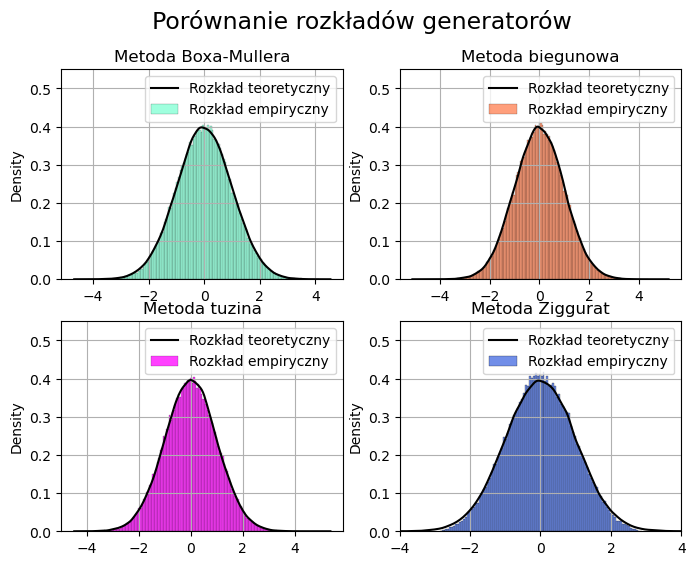

In [10]:
plt.figure(figsize=(8,6))
plt.suptitle('Porównanie rozkładów generatorów', fontsize=17)

plt.subplot(2,2,1)
sns.histplot(box_muller(size=10**5), stat='density', label='Rozkład empiryczny', color='aquamarine')
sns.kdeplot(np.random.normal(loc=0,scale=1,size=10**5), label='Rozkład teoretyczny', color='black')
plt.ylim(0,0.55)
plt.grid()
plt.legend(loc='upper right')
plt.title('Metoda Boxa-Mullera')

plt.subplot(2,2,2)
sns.histplot(biegunowa(size=10**5), stat='density', label='Rozkład empiryczny', color='coral')
sns.kdeplot(np.random.normal(loc=0,scale=1,size=10**5), label='Rozkład teoretyczny', color='black')
plt.ylim(0,0.55)
plt.grid()
plt.legend(loc='upper right')
plt.title('Metoda biegunowa')

plt.subplot(2,2,3)
sns.histplot(tuzin(size=10**5), stat='density', label='Rozkład empiryczny', color='magenta')
sns.kdeplot(np.random.normal(loc=0,scale=1,size=10**5), label='Rozkład teoretyczny', color='black')
plt.ylim(0,0.55)
plt.grid()
plt.legend(loc='upper right')
plt.title('Metoda tuzina')

plt.subplot(2,2,4)
sns.histplot(ziggurat(size=10**5), stat='density', label='Rozkład empiryczny',  color='royalblue')
sns.kdeplot(np.random.normal(loc=0,scale=1,size=10**5), label='Rozkład teoretyczny', color='black')
plt.ylim(0,0.55)
plt.grid()
plt.legend(loc='upper right')
plt.xlim(-4,4)
plt.title('Metoda Ziggurat')

plt.show()

#### Czas wykonania funkcji

C:\Users\ameli\AppData\Local\Temp\ipykernel_20136\2702042760.py:32: RuntimeWarning: invalid value encountered in sqrt
  x[i] = np.sqrt(-2 * np.log(y[i] * np.sqrt(2 * np.pi)))


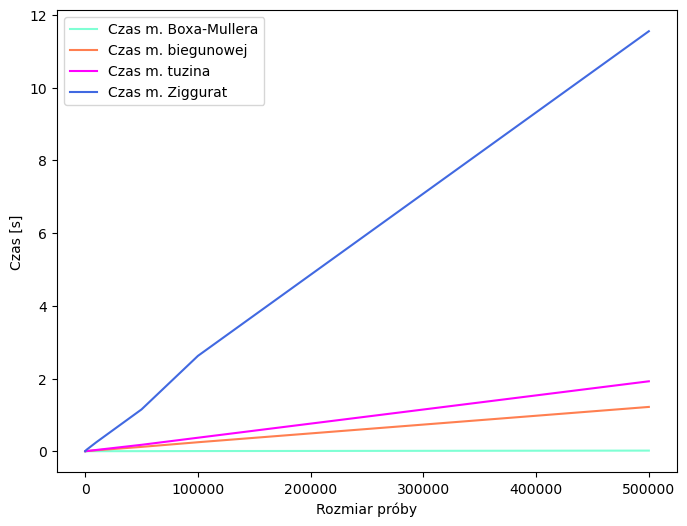

In [11]:
sizes = [10, 10**2, 10**3, 10**4, 5*10**4, 10**5, 5*10**5]

bm_times = [timeit(lambda: box_muller(size=s), number=1) for s in sizes]
biegun_times = [timeit(lambda: biegunowa(size=s), number=1) for s in sizes]
tuzin_times = [timeit(lambda: tuzin(size=s), number=1) for s in sizes]
ziggurat_times = [timeit(lambda: ziggurat(size=s), number=1) for s in sizes]
    
plt.figure(figsize=(8,6))
plt.plot(sizes, bm_times, label='Czas m. Boxa-Mullera', color='aquamarine')
plt.plot(sizes, biegun_times, label='Czas m. biegunowej', color='coral')
plt.plot(sizes, tuzin_times, label='Czas m. tuzina', color='magenta')
plt.plot(sizes, ziggurat_times, label='Czas m. Ziggurat', color='royalblue')

plt.xlabel('Rozmiar próby')
plt.ylabel('Czas [s]')
plt.legend()
plt.show()

#### Parametry statystyczne

In [12]:
pd.DataFrame({
    'Statystyka': ['Średnia', 'Wariancja'],
    'NumPy': [np.mean(np.random.normal(loc=0,scale=1,size=10**5)), np.var(np.random.normal(loc=0,scale=1,size=10**5))],
    'Algorytm Box-Mullera': [np.mean(box_muller(size=10**5)), np.var(box_muller(size=10**5))],
    'Algorytm biegunowy': [np.mean(biegunowa(size=10**5)), np.var(biegunowa(size=10**5))],
    'Algorytm tuzina': [np.mean(tuzin(size=10**5)), np.var(tuzin(size=10**5))],
    'Algorytm Ziggurat': [np.mean(ziggurat(size=10**5)), np.var(ziggurat(size=10**5))]
})

C:\Users\ameli\AppData\Local\Temp\ipykernel_20136\2702042760.py:32: RuntimeWarning: invalid value encountered in sqrt
  x[i] = np.sqrt(-2 * np.log(y[i] * np.sqrt(2 * np.pi)))


,Statystyka,NumPy,Algorytm Box-Mullera,Algorytm biegunowy,Algorytm tuzina,Algorytm Ziggurat
0,Średnia,-0.004142,-0.004087,-0.000902,-0.002471,0.002252
1,Wariancja,1.001901,1.001679,1.005338,1.010324,0.900231


Dla zaimplementowanych algorytmów rozkłady generowanych liczb pseudolosowych zgadzają się z rozkładem normalnym. 

Czas działania jest najszybszy dla metody Boxa-Mullera, najdłużej zajmuje metoda tuzina. Metoda Boxa-Mullera ma również najbardziej zbliżoną średnią oraz wariancję rozkładu do rozkładu wyznaczonego z pakietu NumPy. Dla porównanych czterech algorytmów metodę Boxa-Mullera można nazwać najlepszą do generowania liczb pseudolosowych z rozkładu normalnego.